In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 't').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)

    return inputs, labels

In [3]:
def plot_decision_boundary(X, y, theta, save_path: str):
    """Plots the decision boundary for a logistic regression model using theta."""

    # Extract parameters from theta
    w0, w1, w2 = theta[0], theta[1], theta[2] #theta vector from model.get_theta()

    # Create meshgrid
    x_min, x_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    y_min, y_max = X[:, 2].min() - 0.5, X[:, 2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


    # Calculate decision boundary (w0 + w1*x + w2*y = 0  => y = (-w0 -w1*x)/w2 )
    Z = - (w0 + w1 * xx) / w2  #Decision boundary


    # Plot the decision boundary and data points.
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, (Z > 0).astype(int), alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.RdBu, edgecolors='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.savefig(save_path)
    plt.show()

In [4]:
class LogisticRegression:
    def __init__(self, tolerance=1e-5, max_iter=1000):
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.theta = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cost_function(self, X, y):
        m = len(y)
        h = self.sigmoid(X @ self.theta)
        cost = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
        return cost

    def gradient(self, X, y):
        m = len(y)
        h = self.sigmoid(X @ self.theta)
        grad = (X.T @ (h - y)) / m
        return grad

    def hessian(self, X, y):
        m = len(y)
        h = self.sigmoid(X @ self.theta)
        diag_matrix = np.diag(h * (1 - h))
        hessian = (X.T @ diag_matrix @ X) / m
        return hessian

    def fit(self, X, y, theta_init=None):
        if theta_init is None:
            self.theta = np.zeros(X.shape[1])
        else:
            self.theta = theta_init
        theta_prev = self.theta + 2 * self.tolerance
        iteration = 0

        while np.linalg.norm(self.theta - theta_prev) > self.tolerance and iteration < self.max_iter:
            iteration += 1
            theta_prev = self.theta
            gradient_val = self.gradient(X, y)
            hessian_val = self.hessian(X, y)

            try:
                self.theta = self.theta - np.linalg.solve(hessian_val, gradient_val)
            except np.linalg.LinAlgError:
                print("Hessian matrix is singular. Newton-Raphson method failed to converge.")
                self.theta = theta_prev  # Return the last theta before failure
                return

        print(f"Converged after {iteration} iterations.")

    def predict(self, X):
        probability = self.sigmoid(X @ self.theta)
        return (probability >= 0.5).astype(int)
    
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.sum(y_pred == y) / len(y)
        return accuracy
    
    def get_theta(self):
        return self.theta

In [5]:
def main(train_path, valid_path, save_path):
    """Problem: Logistic regression with Newton's Method.

    Args:
        train_path: Path to CSV file containing dataset for training.
        valid_path: Path to CSV file containing dataset for validation.
        save_path: Path to save predicted probabilities using np.savetxt().
    """
    x_train, y_train = load_dataset(train_path, add_intercept=True)
    model = LogisticRegression()
    model.fit(x_train, y_train)

    predictions = model.predict(x_train)
    accuracy = model.accuracy(x_train,y_train)
    print("Predictions:", predictions)
    print("Accuracy:", accuracy)
#     print(model.get_theta())
    #plot the decision boundary
    plot_decision_boundary(x_train, y_train, model.get_theta(), save_path)
#     print(model.get_theta())

    # *** START CODE HERE ***
    # Train a logistic regression classifier
    # Plot decision boundary on top of validation set set
    # Use np.savetxt to save predictions on eval set to save_path
    # *** END CODE HERE ***

Converged after 7 iterations.
Predictions: [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0
 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1
 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 

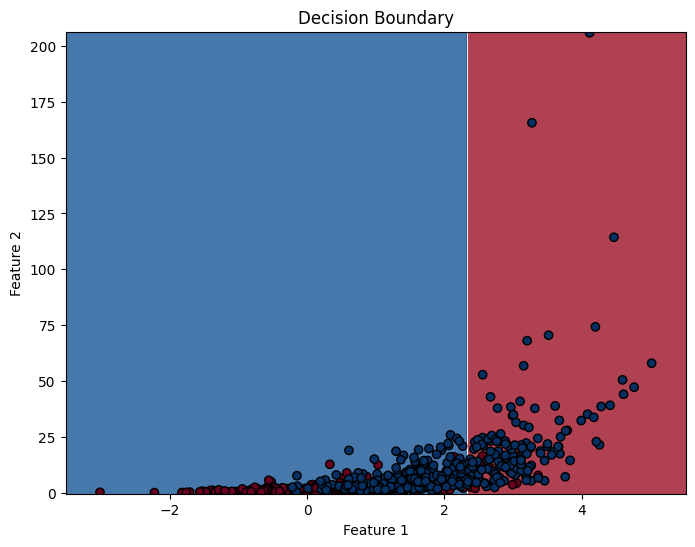

Converged after 6 iterations.
Predictions: [1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0
 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1
 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1
 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 

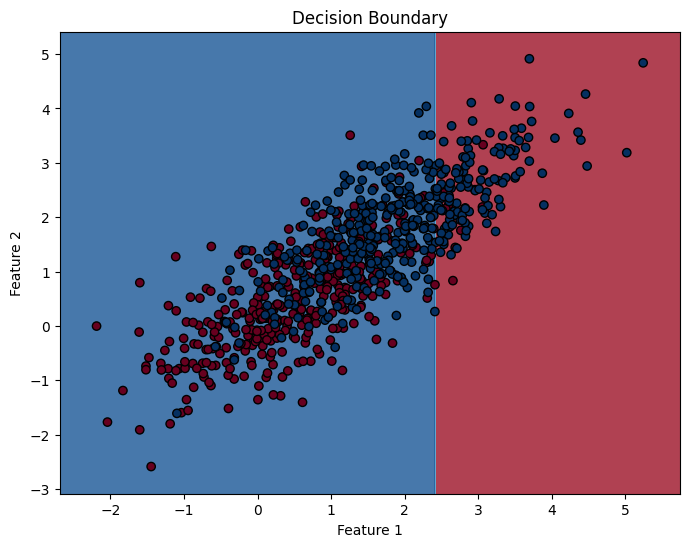

In [7]:
import os

base_dir = os.getcwd()


if __name__ == '__main__':
    linear_path = f'{base_dir}/src/linearclass'
    main(train_path=f'{linear_path}/ds1_train.csv',
         valid_path=f'{linear_path}/ds1_valid.csv',
         save_path=f'{linear_path}/Newton_pred_dataset1.png')

    main(train_path=f'{linear_path}/ds2_train.csv',
         valid_path=f'{linear_path}/ds2_valid.csv',
         save_path=f'{linear_path}/Newton_pred_dataset2.png')